In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import trajCellPoseSr as cellTraj
import h5py
import pickle
import subprocess
import pandas
import re
import scipy
import string, itertools
from scipy import stats
from scipy.integrate import simps
from datetime import date

In [2]:
nstates_init = 7
today = date.today()
date2day = today.strftime("%b%d-%Y")
trajl = 40
nPCs = 10
nUMP = 0
wellInfo = 'A'
trajl_cc = 190

In [3]:
figid = 'LI204601_P_tlen'+str(trajl)+'_'+date2day+'_nS'+str(nstates_init) 
# read cross-correlations for several ligand conditions 
cond0 = ['OSM1','EGF1','EGFTGFB1','TGFB1','PBS1','OSMEGFTGFB','OSMEGF','OSMTGFB']
cond1 = ['OSM2','EGF2','EGFTGFB2','TGFB2','PBS2','OSMEGFTGFB','OSMEGF','OSMTGFB']
cond = []
cond = np.append(cond0[:-3], cond1)
ncond = len(cond)
ncond0 = len(cond0)

In [4]:
datapath = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/crossCorrCCRnuc/'
lenCCR = trajl_cc  # For the time being, may subject to change later
cross_corr_rep_nuc = np.zeros((ncond0, lenCCR)) # Cross-correlations b/w cell-cycle reporter & nuclear channel images
for icond in range(ncond0):
    cor_file = f'LI204601_P_CCRN_SCT_{trajl_cc}_{cond0[icond]}.dat'
    print("Loading file: ", cor_file)
    cor_file_path = datapath+cor_file
    data = np.loadtxt(cor_file_path)
    cross_corr_cond = data[:, 1]
    cross_corr_rep_nuc[icond, :] = cross_corr_cond

Loading file:  LI204601_P_CCRN_SCT_190_OSM1.dat
Loading file:  LI204601_P_CCRN_SCT_190_EGF1.dat
Loading file:  LI204601_P_CCRN_SCT_190_EGFTGFB1.dat
Loading file:  LI204601_P_CCRN_SCT_190_TGFB1.dat
Loading file:  LI204601_P_CCRN_SCT_190_PBS1.dat
Loading file:  LI204601_P_CCRN_SCT_190_OSMEGFTGFB.dat
Loading file:  LI204601_P_CCRN_SCT_190_OSMEGF.dat
Loading file:  LI204601_P_CCRN_SCT_190_OSMTGFB.dat


In [5]:
cross_corr_rep_nuc = np.array(cross_corr_rep_nuc)
inds_dataset0 = np.zeros(ncond0).astype(int)
#inds_dataset1 = np.ones(ncond1).astype(int)
#inds_dataset = np.append(inds_dataset0, inds_dataset1)
inds_dataset = inds_dataset0
inds0 = np.where(inds_dataset == 0)[0]
#inds1 = np.where(inds_dataset == 1)[0]
nsamples = inds_dataset.size
#tmSet = cond0 + cond1
tmSet = cond0 
nLigConds = len(tmSet)

In [6]:
# get morphodynamical state probabilities from imaging analysis: To Change
scmdFilePath = "/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/bulkRNAseq/scripts/"
stProbFile = scmdFilePath+'stProbs_LI204601_P_tlen'+str(trajl)+'_nS'+str(nstates_init)+'pc'+str(nPCs)+'u'+str(nUMP)+wellInfo+'wellsComb.dat' 

if not stProbFile:
  print("ERROR in reading state probability file")
  sys.exit(0)

state_probs = np.loadtxt(stProbFile)
tmSet_imaging = np.array(['OSM1','EGF1','EGFTGFB1','TGFB1','PBS1','OSMEGFTGFB','OSMEGF','OSMTGFB',
                          'OSM2','EGF2','EGFTGFB2','TGFB2','PBS2'])
tmfSet = tmSet #so much fun with names
inds_tmfSet_imaging = np.array([]).astype(int)
for imf in range(len(tmfSet)):
    tm = tmfSet[imf]
    inds_tmfSet_imaging = np.append(inds_tmfSet_imaging, np.where(tmSet_imaging == tm)[0])

inds_tmfSet_Imaging = inds_tmfSet_imaging
state_probs = state_probs[inds_tmfSet_imaging, :]
print("List of all conditions:", np.array(tmSet)[inds_tmfSet_imaging]) # Test + training sets

List of all conditions: ['OSM1' 'EGF1' 'EGFTGFB1' 'TGFB1' 'PBS1' 'OSMEGFTGFB' 'OSMEGF' 'OSMTGFB']


In [12]:
def get_predictedFC(state_probs, statesCCRN):
      n_conds = state_probs.shape[0]
      nStates = state_probs.shape[1]
      nCCRNs = statesCCRN.shape[1]
      cross_corr_rep_nuc_predicted = np.ones((n_conds, nCCRNs))*np.nan
  
      for ic in range(n_conds):
          statep = state_probs[ic, :]
          cross_corr_rep_nuc_predicted[ic, :] = (np.tile(statep, (nCCRNs, 1))*statesCCRN.T).sum(-1)
  
      return cross_corr_rep_nuc_predicted

In [31]:
def get_state_decomposition(cross_corr_rep_nuc, state_probs, ncombinations=500, inds_tm_training=None,
                            save_file=None, visual=False, verbose=True, nchunk=100):
    nStates = state_probs.shape[1] # number of morphodynamic states
    ntr = state_probs.shape[0] # training set conditions
    ntr_measured = cross_corr_rep_nuc.shape[0] # log-fold change values of RNA levels corresponding to training set
    nCCRNs = cross_corr_rep_nuc.shape[1] # Number of CC values along a single-cell trajectory
    if nStates > ntr:
        print(f'error, more states than conditions in state probabilities')
        return
    if nStates > ntr_measured:
        print(f'error, more states than measured bulk conditions')
        return
    cross_corr_rep_nuc_states = np.ones((nStates, nCCRNs))*np.nan
    if inds_tm_training is None:
        inds_tm_training = np.arange(ntr).astype(int)
    ntr_training = inds_tm_training.size
    comb_trainarray = np.array(list(itertools.combinations(inds_tm_training, nStates)))
    ncomb = comb_trainarray.shape[0]
    print(f'{ncomb} possible combinations of {ntr} training measurements decomposed into {nStates} states')
    if ncombinations > ncomb:
        ncombinations = ncomb
    print(f'using {ncombinations} of {ncomb} possible training set combinations randomly per feature')
    for icc in range(nCCRNs):
        # Generate a uniform random sequence from np.arange(ncomb) of size "ncombinations"
        indr = np.random.choice(ncomb, ncombinations, replace=False)
        v_states_comb = np.zeros((ncombinations, nStates))
        for icomb in range(ncombinations):
            indcomb = comb_trainarray[indr[icomb]] # Pick randomized index to remove bias 
            # Pick a ligand condition randomly and use its cross-correlation values
            v_treatments = cross_corr_rep_nuc[indcomb, icc] 
            # Least square linear optimization for each Gene --> solving state_probs*x = v_treatments (fold-change)  
            res = scipy.optimize.lsq_linear(state_probs[indcomb, :], v_treatments, bounds=(lb, ub), verbose=1)
            v_states_comb[icomb, :] = res.x.copy() # x (contribution of each state) is returned from scipy.optimize.lsq_linear 
            # print(f'SD before mean: {v_states_comb[icomb, :]}')
        v_states = np.mean(v_states_comb, axis=0) # Average over all (if more than one!) combinations 
        print(f'State Decompositions: {v_states}')
        cross_corr_rep_nuc_states[:, icc] = v_states.copy() # log-fold change of a selected gene across morphodynamic states
    if save_file is not None:
        np.save(save_file, cross_corr_rep_nuc_states)
    return cross_corr_rep_nuc_states

In [9]:
# Drop Cross-correlations & state probabilities for the ligand
# condition "PBS" to make it "7" conditions "7" Morphodynamic states 
ind_pbs = 4 
state_probs = np.delete(state_probs, ind_pbs, axis = 0)
cross_corr_rep_nuc = np.delete(cross_corr_rep_nuc, ind_pbs, axis = 0)
nStates = state_probs.shape[1] # number of morphodynamic states
lb = np.zeros(nStates)
ub = np.ones(nStates)*np.inf

In [34]:
get_counts = True
if get_counts:
   cross_corr_rep_nuc_states = get_state_decomposition(cross_corr_rep_nuc, state_probs, ncombinations = 500,
                                                       inds_tm_training= None, 
                                                       save_file='statDecom_'+figid+'.npy')
else:
   cross_corr_rep_nuc_states = np.load('statDecom_'+figid+'.npy')

1 possible combinations of 7 training measurements decomposed into 7 states
using 1 of 1 possible training set combinations randomly per feature
The first-order optimality measure is less than `tol`.
Number of iterations 12, initial cost 5.4269e+01, final cost 1.7339e-01, first-order optimality 1.02e-16.
State Decompositions: [1.21060155e+00 1.69348201e+00 9.00412956e-22 1.35836334e-16
 4.21154377e-18 3.48317900e-01 2.35194925e+00]
The first-order optimality measure is less than `tol`.
Number of iterations 9, initial cost 2.9595e+00, final cost 9.7134e-03, first-order optimality 5.05e-12.
State Decompositions: [1.13991256e+00 1.43214916e-09 9.83976070e-01 2.94753352e-10
 7.18013597e-01 1.74978467e+00 1.13786478e-11]
The first-order optimality measure is less than `tol`.
Number of iterations 11, initial cost 1.3699e+01, final cost 3.4926e-02, first-order optimality 2.17e-15.
State Decompositions: [1.04010171e+00 3.27067648e-13 9.92875943e-01 1.42670405e-14
 4.64624242e-01 2.00393215e+00

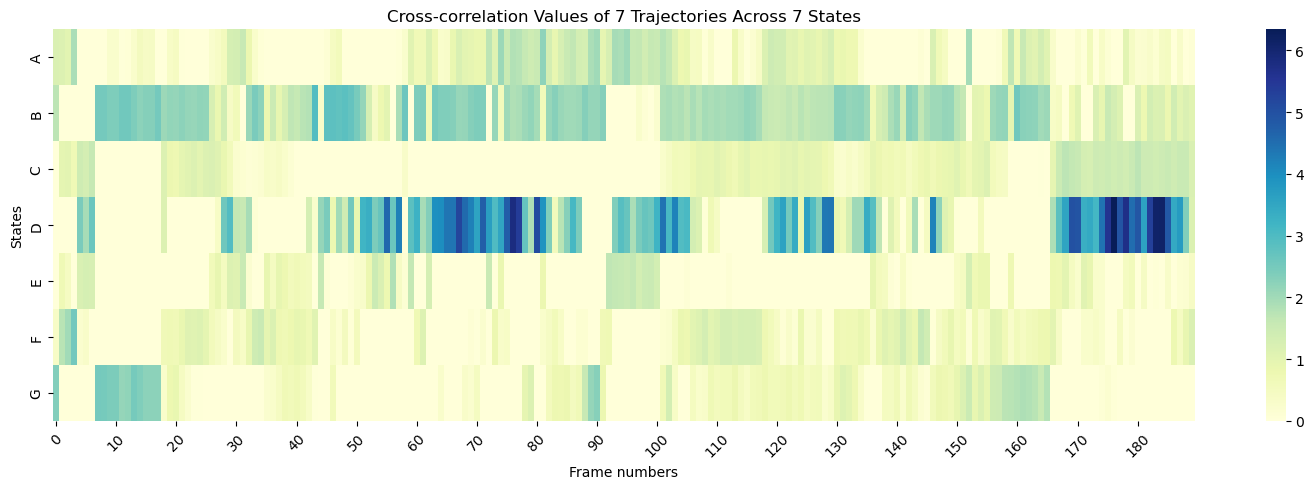

In [29]:
import seaborn as sns
n_states = 7
states = list(string.ascii_uppercase[:n_states])
# Creating a heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(cross_corr_rep_nuc_states, cmap="YlGnBu", xticklabels=10, yticklabels=states)
plt.xticks(rotation=45)
plt.title('Cross-correlation Values of 7 Trajectories Across 7 States')
plt.xlabel('Frame numbers')
plt.ylabel('States')
plt.tight_layout()
#plt.show()
plt.savefig('stateDecomCCvalsSCMD_LI204601_P_tlen40_nS7.png', dpi = 400, bbox_inches = 'tight')

In [13]:
cross_corr_rep_nuc_predicted = get_predictedFC(state_probs, cross_corr_rep_nuc_states)

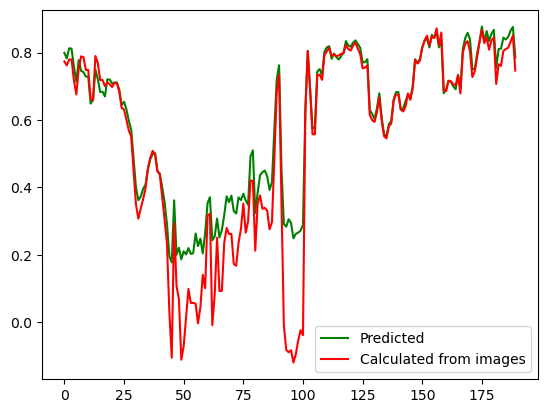

In [22]:
plt.clf()

plt.plot(cross_corr_rep_nuc_predicted[0], color='g', label='Predicted')
plt.plot(cross_corr_rep_nuc[0], color='r', label='Calculated from images')

plt.legend(loc='best')
plt.show()

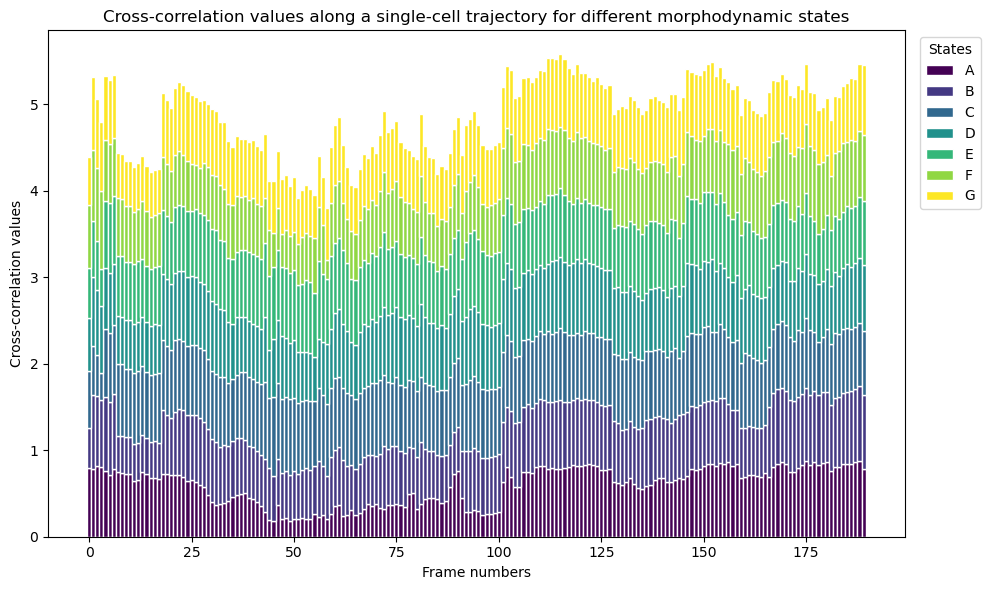

In [30]:
# Number of states and data points
n_states, n_CC_vals = cross_corr_rep_nuc_predicted.shape

states = list(string.ascii_uppercase[:n_states])

# Generate an array of indices for the x-axis
x_indices = np.arange(n_CC_vals)

# Define colors for each condition
colors = plt.cm.viridis(np.linspace(0, 1, n_states))

fig, ax = plt.subplots(figsize=(10, 6))

# Initialize an array to keep track of the cumulative height of the bars
cumulative_heights = np.zeros(n_CC_vals)

for i in range(n_states):
    # Plot each condition as a layer in the stacked bar
    ax.bar(x_indices, cross_corr_rep_nuc_predicted[i], bottom=cumulative_heights, color=colors[i],
           edgecolor='white', width=1, label=states[i])
    # Update the cumulative heights
    cumulative_heights += cross_corr_rep_nuc_predicted[i]

# Customizing the plot
ax.set_xlabel('Frame numbers')
ax.set_ylabel('Cross-correlation values')
ax.set_title('Cross-correlation values along a single-cell trajectory for different morphodynamic states')
ax.legend(title='States', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()
#plt.savefig('statDecomCCvalsSCMD_LI204601_P_tlen40_Feb23-2024_nS7.png', dpi = 400, bbox_inches = 'tight')